# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib as mpl
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Read and process data

In [2]:
# Data processing function for hierarchical model
# Reusing the same function as in the original code
# This function processes the data for hierarchical prediction, including encoding categorical variables and scaling coordinates.
def process_data_hierarchical(df):
    """Process data for hierarchical prediction"""
    # Process continuous features
    cont_cols = [col for col in df.columns if col not in [
        'latitude', 'longitude',
        'latitude_rad', 'longitude_rad', 'x', 'y', 'z',
        'scaled_x', 'scaled_y', 'scaled_z', 'continent', 'city'
    ]]
    
    # Get the features
    x_cont = df[cont_cols].values
    
    # Encode continent labels
    continent_encoder = LabelEncoder()
    y_continent = continent_encoder.fit_transform(df['continent'].values)
    
    # Encode city labels
    city_encoder = LabelEncoder()
    y_city = city_encoder.fit_transform(df['city'].values)
    
    # Calculate coordinates if not already present
    if not all(col in df.columns for col in ['x', 'y', 'z']):
        df['latitude_rad'] = np.deg2rad(df['latitude'])
        df['longitude_rad'] = np.deg2rad(df['longitude'])
        df['x'] = np.cos(df['latitude_rad']) * np.cos(df['longitude_rad'])
        df['y'] = np.cos(df['latitude_rad']) * np.sin(df['longitude_rad'])
        df['z'] = np.sin(df['latitude_rad'])
    
    # Scale coordinates
    coord_scaler = StandardScaler()
    y_coords = coord_scaler.fit_transform(df[['x', 'y', 'z']].values)
    
    continents = continent_encoder.classes_
    cities = city_encoder.classes_
    
    print(f"Continents: {len(continents)} ({continents})")
    print(f"Cities: {len(cities)}")
    print(f"Continuous features: {len(cont_cols)}")
    
    return {
        'x_cont': x_cont,
        'y_continent': y_continent,
        'y_city': y_city,
        'y_coords': y_coords, # This is for neural networks. Scaling is required
        'y_latitude': df['latitude'].values, # This is for XGBoost, we don't need to scale this
        'y_longitude':df['longitude'].values, # This is for XGBoost, we don't need to scale this
        'encoders': {
            'continent': continent_encoder,
            'city': city_encoder,
            'coord': coord_scaler
        },
        'continents': continents,
        'cities': cities
    }

df = pd.read_csv("/home/chandru/binp37/results/metasub/metasub_training_testing_data.csv")
processed_data = process_data_hierarchical(df)

Continents: 7 (['east_asia' 'europe' 'middle_east' 'north_america' 'oceania'
 'south_america' 'sub_saharan_africa'])
Cities: 40
Continuous features: 200


In [3]:
# We get the predictions from the ensemble model for each layer
# These predictions are saved in the 'saved_results' directory
# The predictions are loaded from the saved numpy files
os.chdir("/home/chandru/binp37/scripts/ensemble")
y_test_cont = np.load("saved_results/y_test_cont.npy")
y_pred_cont = np.load("saved_results/y_pred_cont.npy")

y_test_city = np.load("saved_results/y_test_city.npy")
y_pred_city = np.load("saved_results/y_pred_city.npy")

y_test_coords = np.load("saved_results/y_test_coord.npy")
y_pred_coords = np.load("saved_results/y_pred_coord.npy")


In [4]:
# Convert the numpy arrays to pandas DataFrame for easier handling
# This DataFrame will contain true and predicted values for continuous features, city labels, and coordinates
df = pd.DataFrame({
    'true_cont': y_test_cont,
    'pred_cont': y_pred_cont,
    'true_city': y_test_city,
    'pred_city': y_pred_city,
    'true_lat': y_test_coords[:, 0],
    'true_lon': y_test_coords[:, 1],
    'pred_lat': y_pred_coords[:, 0],
    'pred_lon': y_pred_coords[:, 1]
})

In [5]:
# Add the reverse label encoding for continents and cities
# This will help in understanding the predictions better
continents = processed_data['continents']
cities = processed_data['cities']
df['true_cont_name'] = df['true_cont'].map(lambda i: continents[i])
df['pred_cont_name'] = df['pred_cont'].map(lambda i: continents[i])

df['true_city_name'] = df['true_city'].map(lambda i: cities[i])
df['pred_city_name'] = df['pred_city'].map(lambda i: cities[i])

cont_support_map = dict(zip(np.unique(df['true_cont_name'],return_counts=True)[0],np.unique(df['true_cont_name'],return_counts=True)[1]))
city_support_map = dict(zip(np.unique(df['true_city_name'],return_counts=True)[0],np.unique(df['true_city_name'],return_counts=True)[1]))

# Error Analysis

In [6]:
# Compute the error in coordinate predictions
# Functions required for coordinate distance calculation
# Distance between two points on the earth
def haversine_distance(lat1,lon1,lat2,lon2):
    """
    Calculate the great circle distance between two points on the earth
    """
    # Radius of the earth
    R = 6371.0

    # Convert from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2) **2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c # in kilometers


# Step 1: Compute the correctness 
# Compute correctness for continent and city predictions - This the first and second layer of the hierarchical model.
df['continent_correct'] = df['true_cont'] == df['pred_cont']
df['city_correct'] = df['true_city'] == df['pred_city']

# Step 2: Compute coordinates distance
df['coord_error'] = haversine_distance(df['true_lat'].values,df['true_lon'].values,df['pred_lat'].values,df['pred_lon'].values)

# Print the general statistics of the coordinate predictions
print(f'The median distance error is {np.median(df["coord_error"].values)}')
print(f'The mean distance error is {np.mean(df["coord_error"].values)}')
print(f'The max distance error is {np.max(df["coord_error"].values)}')

The median distance error is 13.718801498413086
The mean distance error is 589.0228271484375
The max distance error is 17919.697265625


In [7]:
# Sort the DataFrame by 'coord_error' in descending order
# This will help in identifying the largest errors in coordinate predictions
df_sorted = df.sort_values(by='coord_error', ascending=False)   
print("Top 10 largest coordinate errors:")
df_sorted[['true_city_name', 'pred_city_name', 'true_cont_name', 'pred_cont_name','true_lat','pred_lat','true_lon','pred_lon',
            'coord_error']].head(10)

Top 10 largest coordinate errors:


,true_city_name,pred_city_name,true_cont_name,pred_cont_name,true_lat,pred_lat,true_lon,pred_lon,coord_error
86,sao_paulo,seoul,south_america,east_asia,-23.561726,17.567816,-46.656693,114.238235,17919.697266
254,tokyo,porto,east_asia,europe,35.605324,29.039177,139.682404,-49.680927,12760.339844
703,brisbane,kyiv,oceania,sub_saharan_africa,-27.420399,28.626568,152.992477,50.282738,12574.187500
510,sao_paulo,singapore,south_america,europe,-23.561686,28.400463,-46.656864,53.098648,12128.223633
44,zurich,fairbanks,europe,north_america,47.000000,36.913471,8.000000,-153.516876,10504.365234
533,zurich,singapore,europe,east_asia,47.000000,3.846595,8.000000,102.398430,10027.437500
542,tokyo,minneapolis,east_asia,north_america,35.640141,34.921383,139.631577,-105.083786,9695.548828
42,san_francisco,san_francisco,north_america,north_america,37.766602,38.329765,122.448097,-124.134026,9155.278320
151,tokyo,minneapolis,east_asia,north_america,35.640194,37.423676,139.631531,-125.245689,8089.869629
667,lisbon,fairbanks,europe,north_america,38.753819,44.206112,-9.230830,-109.182175,7798.346680


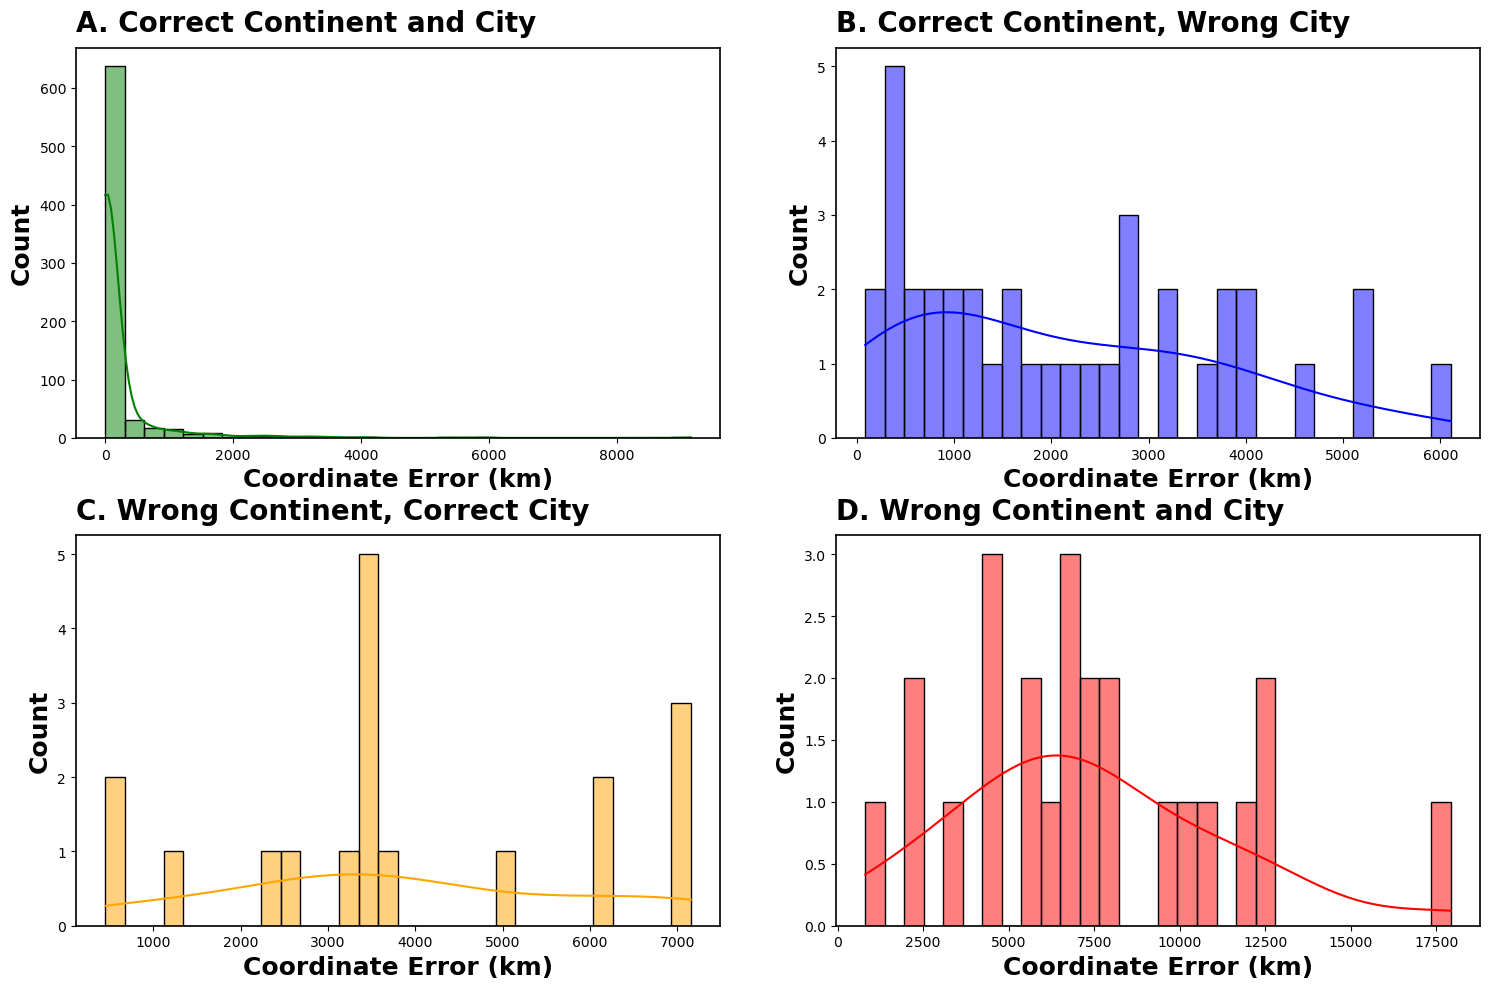

In [8]:
# Distribution of coordinate errors for each category
# This will help in understanding the performance of the model, given the hierarchical nature of the predictions.
# We will create four categories based on the correctness of continent and city predictions:
# 1. Correct continent and city predictions
# 2. Correct continent predictions, wrong city predictions
# 3. Correct city predictions, wrong continent predictions
# 4. Wrong continent and city predictions

# Get the dataset that has correct continent and city predictions and sort the coord error from high to low
correct_df = df[(df['continent_correct']) & (df['city_correct'])]
correct_df = correct_df.sort_values(by='coord_error', ascending=False)
# Get the dataset that has correct contient by wrong city predictions and sort the coord error from high to low
correct_cont_df = df[(df['continent_correct']) & (~df['city_correct'])]
correct_cont_df = correct_cont_df.sort_values(by='coord_error', ascending=False)
# Get the dataset that has correct city by wrong continent predictions and sort the coord error from high to low
correct_city_df = df[(~df['continent_correct']) & (df['city_correct'])]
correct_city_df = correct_city_df.sort_values(by='coord_error', ascending=False)
# Get the dataset that has wrong continent and city predictions and sort the coord error from high to low
wrong_df = df[(~df['continent_correct']) & (~df['city_correct'])]
wrong_df = wrong_df.sort_values(by='coord_error', ascending=False)

mpl.rcParams.update({
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,
    'font.family': 'DejaVu Sans'
})

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=False)

# (A) Correct Continent and City Predictions
sns.histplot(correct_df['coord_error'], bins=30, kde=True, color='green', ax=axes[0, 0])
axes[0, 0].set_title('A. Correct Continent and City', loc='left', fontweight='bold', fontsize=20, pad=12)
axes[0, 0].set_xlabel('Coordinate Error (km)')
axes[0, 0].set_ylabel('Count')

# (B) Correct Continent, Wrong City
sns.histplot(correct_cont_df['coord_error'], bins=30, kde=True, color='blue', ax=axes[0, 1])
axes[0, 1].set_title('B. Correct Continent, Wrong City', loc='left', fontweight='bold', fontsize=20, pad=12)
axes[0, 1].set_xlabel('Coordinate Error (km)')
axes[0, 1].set_ylabel('Count')

# (C) Wrong Continent, Correct City
sns.histplot(correct_city_df['coord_error'], bins=30, kde=True, color='orange', ax=axes[1, 0])
axes[1, 0].set_title('C. Wrong Continent, Correct City', loc='left', fontweight='bold', fontsize=20, pad=12)
axes[1, 0].set_xlabel('Coordinate Error (km)')
axes[1, 0].set_ylabel('Count')

# (D) Wrong Continent and City
sns.histplot(wrong_df['coord_error'], bins=30, kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_title('D. Wrong Continent and City', loc='left', fontweight='bold', fontsize=20, pad=12)
axes[1, 1].set_xlabel('Coordinate Error (km)')
axes[1, 1].set_ylabel('Count')

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.25, wspace=0.18)

# Optionally, save the figure
# fig.savefig('/home/chandru/binp37/report/figures/coord_error_distribution_by_group.png', dpi=600, bbox_inches='tight')

plt.show()


In [11]:
# Get ROC AUC for continent and city - This a multiclass classification problem

# Binarize the true labels for ROC AUC calculation
y_true_cont_binarized = label_binarize(y_test_cont, classes=np.arange(len(processed_data['continents'])))
y_true_city_binarized = label_binarize(y_test_city, classes=np.arange(len(processed_data['cities'])))

# Calculate ROC AUC for continent and city (OVA)
roc_auc_continent_ova = roc_auc_score(
    y_true_cont_binarized,
    label_binarize(y_pred_cont, classes=np.arange(len(processed_data['continents']))),
    average='macro',
    multi_class='ovr'
)
roc_auc_city_ova = roc_auc_score(
    y_true_city_binarized,
    label_binarize(y_pred_city, classes=np.arange(len(processed_data['cities']))),
    average='macro',
    multi_class='ovr'
)

# Calculate ROC AUC for continent and city (OVO)
roc_auc_continent_ovo = roc_auc_score(
    y_true_cont_binarized,
    label_binarize(y_pred_cont, classes=np.arange(len(processed_data['continents']))),
    average='macro',
    multi_class='ovo'
)
roc_auc_city_ovo = roc_auc_score(
    y_true_city_binarized,
    label_binarize(y_pred_city, classes=np.arange(len(processed_data['cities']))),
    average='macro',
    multi_class='ovo'
)

# Calculate Precision-Recall AUC for continent and city
precision_cont, recall_cont, _ = precision_recall_curve(
    y_true_cont_binarized.ravel(),
    label_binarize(y_pred_cont, classes=np.arange(len(processed_data['continents']))).ravel()
)
prc_auc_continent = auc(recall_cont, precision_cont)

precision_city, recall_city, _ = precision_recall_curve(
    y_true_city_binarized.ravel(),
    label_binarize(y_pred_city, classes=np.arange(len(processed_data['cities']))).ravel()
)
prc_auc_city = auc(recall_city, precision_city)

# --- Multiclass ROC AUC and Precision-Recall AUC (AUPR) Calculation ---

# Binarize true and predicted labels for continent and city
y_true_cont_binarized = label_binarize(y_test_cont, classes=np.arange(len(processed_data['continents'])))
y_pred_cont_binarized = label_binarize(y_pred_cont, classes=np.arange(len(processed_data['continents'])))
y_true_city_binarized = label_binarize(y_test_city, classes=np.arange(len(processed_data['cities'])))
y_pred_city_binarized = label_binarize(y_pred_city, classes=np.arange(len(processed_data['cities'])))

# ROC AUC (macro-average) for continent and city (OVA and OVO)
roc_auc_continent_ova = roc_auc_score(y_true_cont_binarized, y_pred_cont_binarized, average='macro', multi_class='ovr')
roc_auc_continent_ovo = roc_auc_score(y_true_cont_binarized, y_pred_cont_binarized, average='macro', multi_class='ovo')
roc_auc_city_ova = roc_auc_score(y_true_city_binarized, y_pred_city_binarized, average='macro', multi_class='ovr')
roc_auc_city_ovo = roc_auc_score(y_true_city_binarized, y_pred_city_binarized, average='macro', multi_class='ovo')

# Precision-Recall curve and AUPR (macro-average) for continent and city
precision_cont, recall_cont, _ = precision_recall_curve(y_true_cont_binarized.ravel(), y_pred_cont_binarized.ravel())
aupr_continent = auc(recall_cont, precision_cont)

precision_city, recall_city, _ = precision_recall_curve(y_true_city_binarized.ravel(), y_pred_city_binarized.ravel())
aupr_city = auc(recall_city, precision_city)

print(f"ROC AUC (Continent, OVA): {roc_auc_continent_ova:.3f}")
print(f"ROC AUC (Continent, OVO): {roc_auc_continent_ovo:.3f}")
print(f"ROC AUC (City, OVA): {roc_auc_city_ova:.3f}")
print(f"ROC AUC (City, OVO): {roc_auc_city_ovo:.3f}")
print(f"AUPR (Continent): {aupr_continent:.3f}")
print(f"AUPR (City): {aupr_city:.3f}")


ROC AUC (Continent, OVA): 0.928
ROC AUC (Continent, OVO): 0.928
ROC AUC (City, OVA): 0.905
ROC AUC (City, OVO): 0.905
AUPR (Continent): 0.952
AUPR (City): 0.926


Sensitivity (Continent): 0.866
Specificity (Continent): 0.917
Sensitivity (City): 0.811
Specificity (City): 0.854


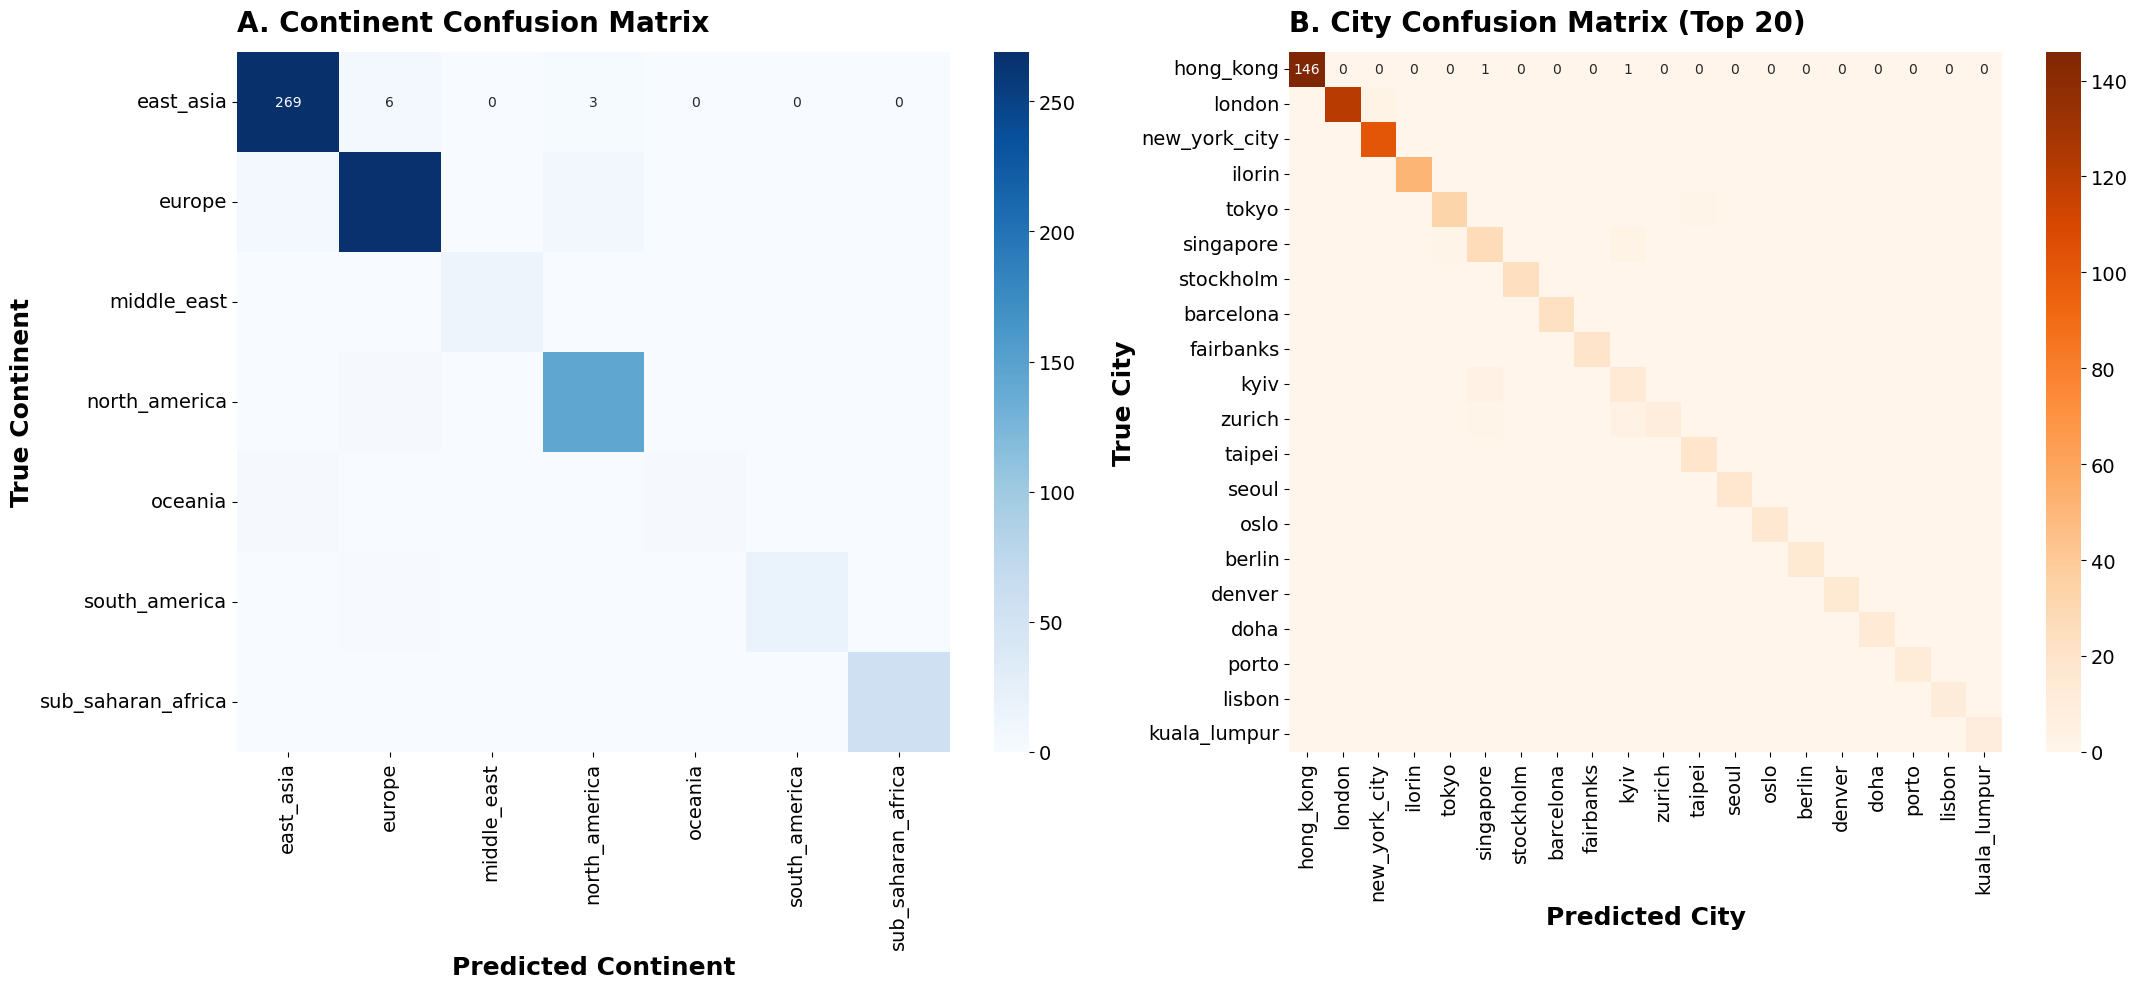

In [12]:
# Calculate sensitivity and specificity for each class in multiclass classification
# Sensitivity (True Positive Rate) and Specificity (True Negative Rate) are calculated from the confusion matrix.
# Sensitivity is the proportion of actual positives that are correctly identified.
# Specificity is the proportion of actual negatives that are correctly identified.
# Plot the confusion matrix for continent and city predictions


def calculate_sensitivity_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.diag(cm) / np.sum(cm, axis=1)  # True Positive Rate
    specificity = np.full(cm.shape[0], np.nan)
    col_sums = np.sum(cm, axis=0)
    for i in range(cm.shape[0]):
        if col_sums[i] > 0:
            specificity[i] = cm[i, i] / col_sums[i]
    return sensitivity, specificity, cm

sensitivity_cont, specificity_cont, cm_cont = calculate_sensitivity_specificity(y_test_cont, y_pred_cont)
sensitivity_city, specificity_city, cm_city = calculate_sensitivity_specificity(y_test_city, y_pred_city)

# Print the sensitivity and specificity for continent and city predictions
print(f"Sensitivity (Continent): {np.nanmean(sensitivity_cont):.3f}")
print(f"Specificity (Continent): {np.nanmean(specificity_cont):.3f}")
print(f"Sensitivity (City): {np.nanmean(sensitivity_city):.3f}")
print(f"Specificity (City): {np.nanmean(specificity_city):.3f}")

# Note: In multiclass, specificity per class is only defined for classes with at least one prediction.
# np.nanmean ignores classes with no predictions.

# Plot confusion matrix for continent and city predictions as publication quality figures

mpl.rcParams.update({
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,
    'font.family': 'DejaVu Sans'
})

# Prepare top 20 cities for city confusion matrix
top_cities = df['true_city_name'].value_counts().nlargest(20).index
city_indices = [np.where(processed_data['cities'] == city)[0][0] for city in top_cities]
cm_city_top = cm_city[np.ix_(city_indices, city_indices)]

fig, axes = plt.subplots(1, 2, figsize=(22, 10))


# (A) Continent confusion matrix
sns.heatmap(
    cm_cont, annot=True, fmt='d', cmap='Blues', cbar=True,
    xticklabels=processed_data['continents'],
    yticklabels=processed_data['continents'],
    ax=axes[0]
)
axes[0].set_xlabel('Predicted Continent', fontsize=18, fontweight='bold')
axes[0].set_ylabel('True Continent', fontsize=18, fontweight='bold')
axes[0].set_title('A. Continent Confusion Matrix', fontsize=20, fontweight='bold', pad=15, loc='left')

# (B) City confusion matrix (top 20)
sns.heatmap(
    cm_city_top, annot=True, fmt='d', cmap='Oranges', cbar=True,
    xticklabels=top_cities,
    yticklabels=top_cities,
    ax=axes[1]
)
axes[1].set_xlabel('Predicted City', fontsize=18, fontweight='bold')
axes[1].set_ylabel('True City', fontsize=18, fontweight='bold')
axes[1].set_title('B. City Confusion Matrix (Top 20)', fontsize=20, fontweight='bold', pad=15, loc='left')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
# plt.savefig('/home/chandru/binp37/report/figures/confusion_matrix_continent_city.png', dpi=600, bbox_inches='tight')
plt.show()

In [16]:
# Step 3: Group into the 4 categories
# We will create a new column 'error_group' in the DataFrame that categorizes each row based on the correctness of continent and city predictions. 
# The categories are:
# 1. Correct continent and city predictions
# 2. Correct continent predictions, wrong city predictions
# 3. Correct city predictions, wrong continent predictions
# 4. Wrong continent and city predictions
# This will help in analyzing the errors in a more structured way.

def group_label(row):
    if row['continent_correct'] and row['city_correct']:
        return 'C_correct Z_correct'
    elif row['continent_correct'] and not row['city_correct']:
        return 'C_correct Z_wrong'
    elif not row['continent_correct'] and row['city_correct']:
        return 'C_wrong Z_correct'
    else:
        return 'C_wrong Z_wrong'

df['error_group'] = df.apply(group_label, axis=1)

# Step 4: Aggregate stats
# Group by 'error_group' and calculate statistics for coordinate errors
# This will give us the count, mean, and median of coordinate errors for each error group
group_stats = df.groupby('error_group')['coord_error'].agg([
    ('count', 'count'),
    ('mean_error_km', 'mean'),
    ('median_error_km', 'median')
])


# Step 5: Calculate proportions and expected error
# Calculate the proportion of each error group in the dataset
total = len(df)
group_stats['proportion'] = group_stats['count'] / total
group_stats['weighted_error'] = group_stats['mean_error_km'] * group_stats['proportion']
expected_total_error = group_stats['weighted_error'].sum()
print("\nError Group Statistics:")
print(group_stats)
print(f"\nExpected Coordinate Error E[D]: {expected_total_error:.2f} km") # It is the same as mean error, but we calculate it to show the expected error based on the distribution of errors in each group.



Error Group Statistics:
                     count  mean_error_km  median_error_km  proportion  \
error_group                                                              
C_correct Z_correct    735     208.126068        12.334869    0.902948   
C_correct Z_wrong       37    2148.086182      1713.463135    0.045455   
C_wrong Z_correct       18    3902.223877      3534.171387    0.022113   
C_wrong Z_wrong         24    7365.528809      6822.907715    0.029484   

                     weighted_error  
error_group                          
C_correct Z_correct      187.927101  
C_correct Z_wrong         97.640281  
C_wrong Z_correct         86.289963  
C_wrong Z_wrong          217.165469  

Expected Coordinate Error E[D]: 589.02 km


In [ ]:
# Step 6: Compute in-radius metrics
# This function computes the percentage of predictions that fall within specified distance thresholds.
def compute_in_radius_metrics(y_true, y_pred, thresholds=[1, 5, 50, 100, 250, 500, 1000, 5000]):
    """
    Compute % of predictions within given distance thresholds
    y_true, y_pred: numpy arrays of shape (N, 2) for [lat, lon]
    """
    distances = haversine_distance(
        y_true[:, 0], y_true[:, 1], y_pred[:, 0], y_pred[:, 1]
    )

    results = {}
    for r in thresholds:
        percent = np.mean(distances <= r) * 100
        results[f"<{r} km"] = percent
    
    return results, distances

metrics, dists = compute_in_radius_metrics(y_test_coords, y_pred_coords)

print("In-Radius Accuracy Metrics:")
for k, v in metrics.items():
    print(f"{k:>8}: {v:.2f}%")


In-Radius Accuracy Metrics:
   <1 km: 0.00%
   <5 km: 4.18%
  <50 km: 68.55%
 <100 km: 72.85%
 <250 km: 77.27%
 <500 km: 81.94%
<1000 km: 86.61%
<5000 km: 96.44%


In [17]:
def in_radius_by_group(df, group_col, thresholds=[1, 5, 50, 100, 250, 500, 1000, 5000]):
    """
    Compute in-radius accuracy for a group column (continent, city, or continent+city)
    """
    df = df.copy()
    df['coord_error'] = haversine_distance(
        df['true_lat'].values, df['true_lon'].values,
        df['pred_lat'].values, df['pred_lon'].values
    )

    results = {}
    grouped = df.groupby(group_col)
    
    for group_name, group_df in grouped:
        res = {}
        errors = group_df['coord_error'].values
        for r in thresholds:
            res[f"<{r} km"] = np.mean(errors <= r) * 100  # in %
        results[group_name] = res
    
    return pd.DataFrame(results).T  # Transpose for better readability


In [18]:
continent_metrics = in_radius_by_group(df, group_col='true_cont_name')
print("In-Radius Accuracy per Continent")
continent_metrics['continent_support'] = continent_metrics.index.map(cont_support_map)
continent_metrics.round(2)

In-Radius Accuracy per Continent


,<1 km,<5 km,<50 km,<100 km,<250 km,<500 km,<1000 km,<5000 km,continent_support
east_asia,0.0,7.55,73.38,77.34,80.94,84.53,89.21,97.84,278
europe,0.0,3.89,67.49,72.44,78.09,82.33,86.22,95.05,283
middle_east,0.0,0.00,80.00,80.00,86.67,93.33,100.00,100.00,15
north_america,0.0,1.34,63.76,67.79,73.15,81.21,85.91,97.99,149
oceania,0.0,0.00,0.00,0.00,0.00,0.00,0.00,55.56,9
south_america,0.0,0.00,28.57,38.10,42.86,57.14,66.67,90.48,21
sub_saharan_africa,0.0,0.00,84.75,88.14,88.14,88.14,94.92,100.00,59


In [19]:
city_metrics = in_radius_by_group(df, group_col='true_city_name')
print("In-Radius Accuracy per City")
city_metrics['city_support'] = city_metrics.index.map(city_support_map)
city_metrics.round(2)

In-Radius Accuracy per City


,<1 km,<5 km,<50 km,<100 km,<250 km,<500 km,<1000 km,<5000 km,city_support
auckland,0.0,0.00,0.00,0.00,0.00,0.00,0.00,100.00,1
baltimore,0.0,0.00,0.00,0.00,0.00,100.00,100.00,100.00,1
barcelona,0.0,8.70,95.65,95.65,95.65,95.65,95.65,100.00,23
berlin,0.0,0.00,66.67,73.33,93.33,93.33,100.00,100.00,15
bogota,0.0,0.00,0.00,25.00,25.00,25.00,25.00,100.00,4
brisbane,0.0,0.00,0.00,0.00,0.00,0.00,0.00,20.00,5
denver,0.0,6.67,73.33,73.33,86.67,93.33,100.00,100.00,15
doha,0.0,0.00,80.00,80.00,86.67,93.33,100.00,100.00,15
fairbanks,0.0,0.00,28.57,28.57,33.33,38.10,52.38,90.48,21
hamilton,0.0,0.00,0.00,0.00,0.00,0.00,0.00,100.00,3


In [100]:
df['continent_city'] = df['true_cont_name'] + " / " + df['true_city_name']
cont_city_metrics = in_radius_by_group(df, group_col='continent_city')
cont_city_metrics['continent_support'] = cont_city_metrics.index.map(lambda x :x.split("/")[-1].strip()).map(city_support_map)
print("In-Radius Accuracy per Continent-City")
cont_city_metrics.round(2)

In-Radius Accuracy per Continent-City


,<1 km,<5 km,<50 km,<100 km,<250 km,<500 km,<1000 km,<5000 km,continent_support
east_asia / hanoi,0.0,0.00,0.00,0.00,0.00,20.00,60.00,100.00,5
east_asia / hong_kong,0.0,4.05,94.59,95.27,95.27,96.62,97.97,100.00,148
east_asia / kuala_lumpur,0.0,0.00,50.00,70.00,90.00,100.00,100.00,100.00,10
east_asia / sendai,0.0,0.00,75.00,100.00,100.00,100.00,100.00,100.00,4
east_asia / seoul,0.0,10.53,57.89,63.16,78.95,84.21,94.74,100.00,19
east_asia / singapore,0.0,3.12,6.25,15.62,21.88,25.00,40.62,90.62,32
east_asia / taipei,0.0,31.58,84.21,94.74,94.74,100.00,100.00,100.00,19
east_asia / tokyo,0.0,15.79,71.05,71.05,76.32,84.21,86.84,92.11,38
east_asia / yamaguchi,0.0,0.00,0.00,33.33,66.67,66.67,100.00,100.00,3
europe / barcelona,0.0,8.70,95.65,95.65,95.65,95.65,95.65,100.00,23


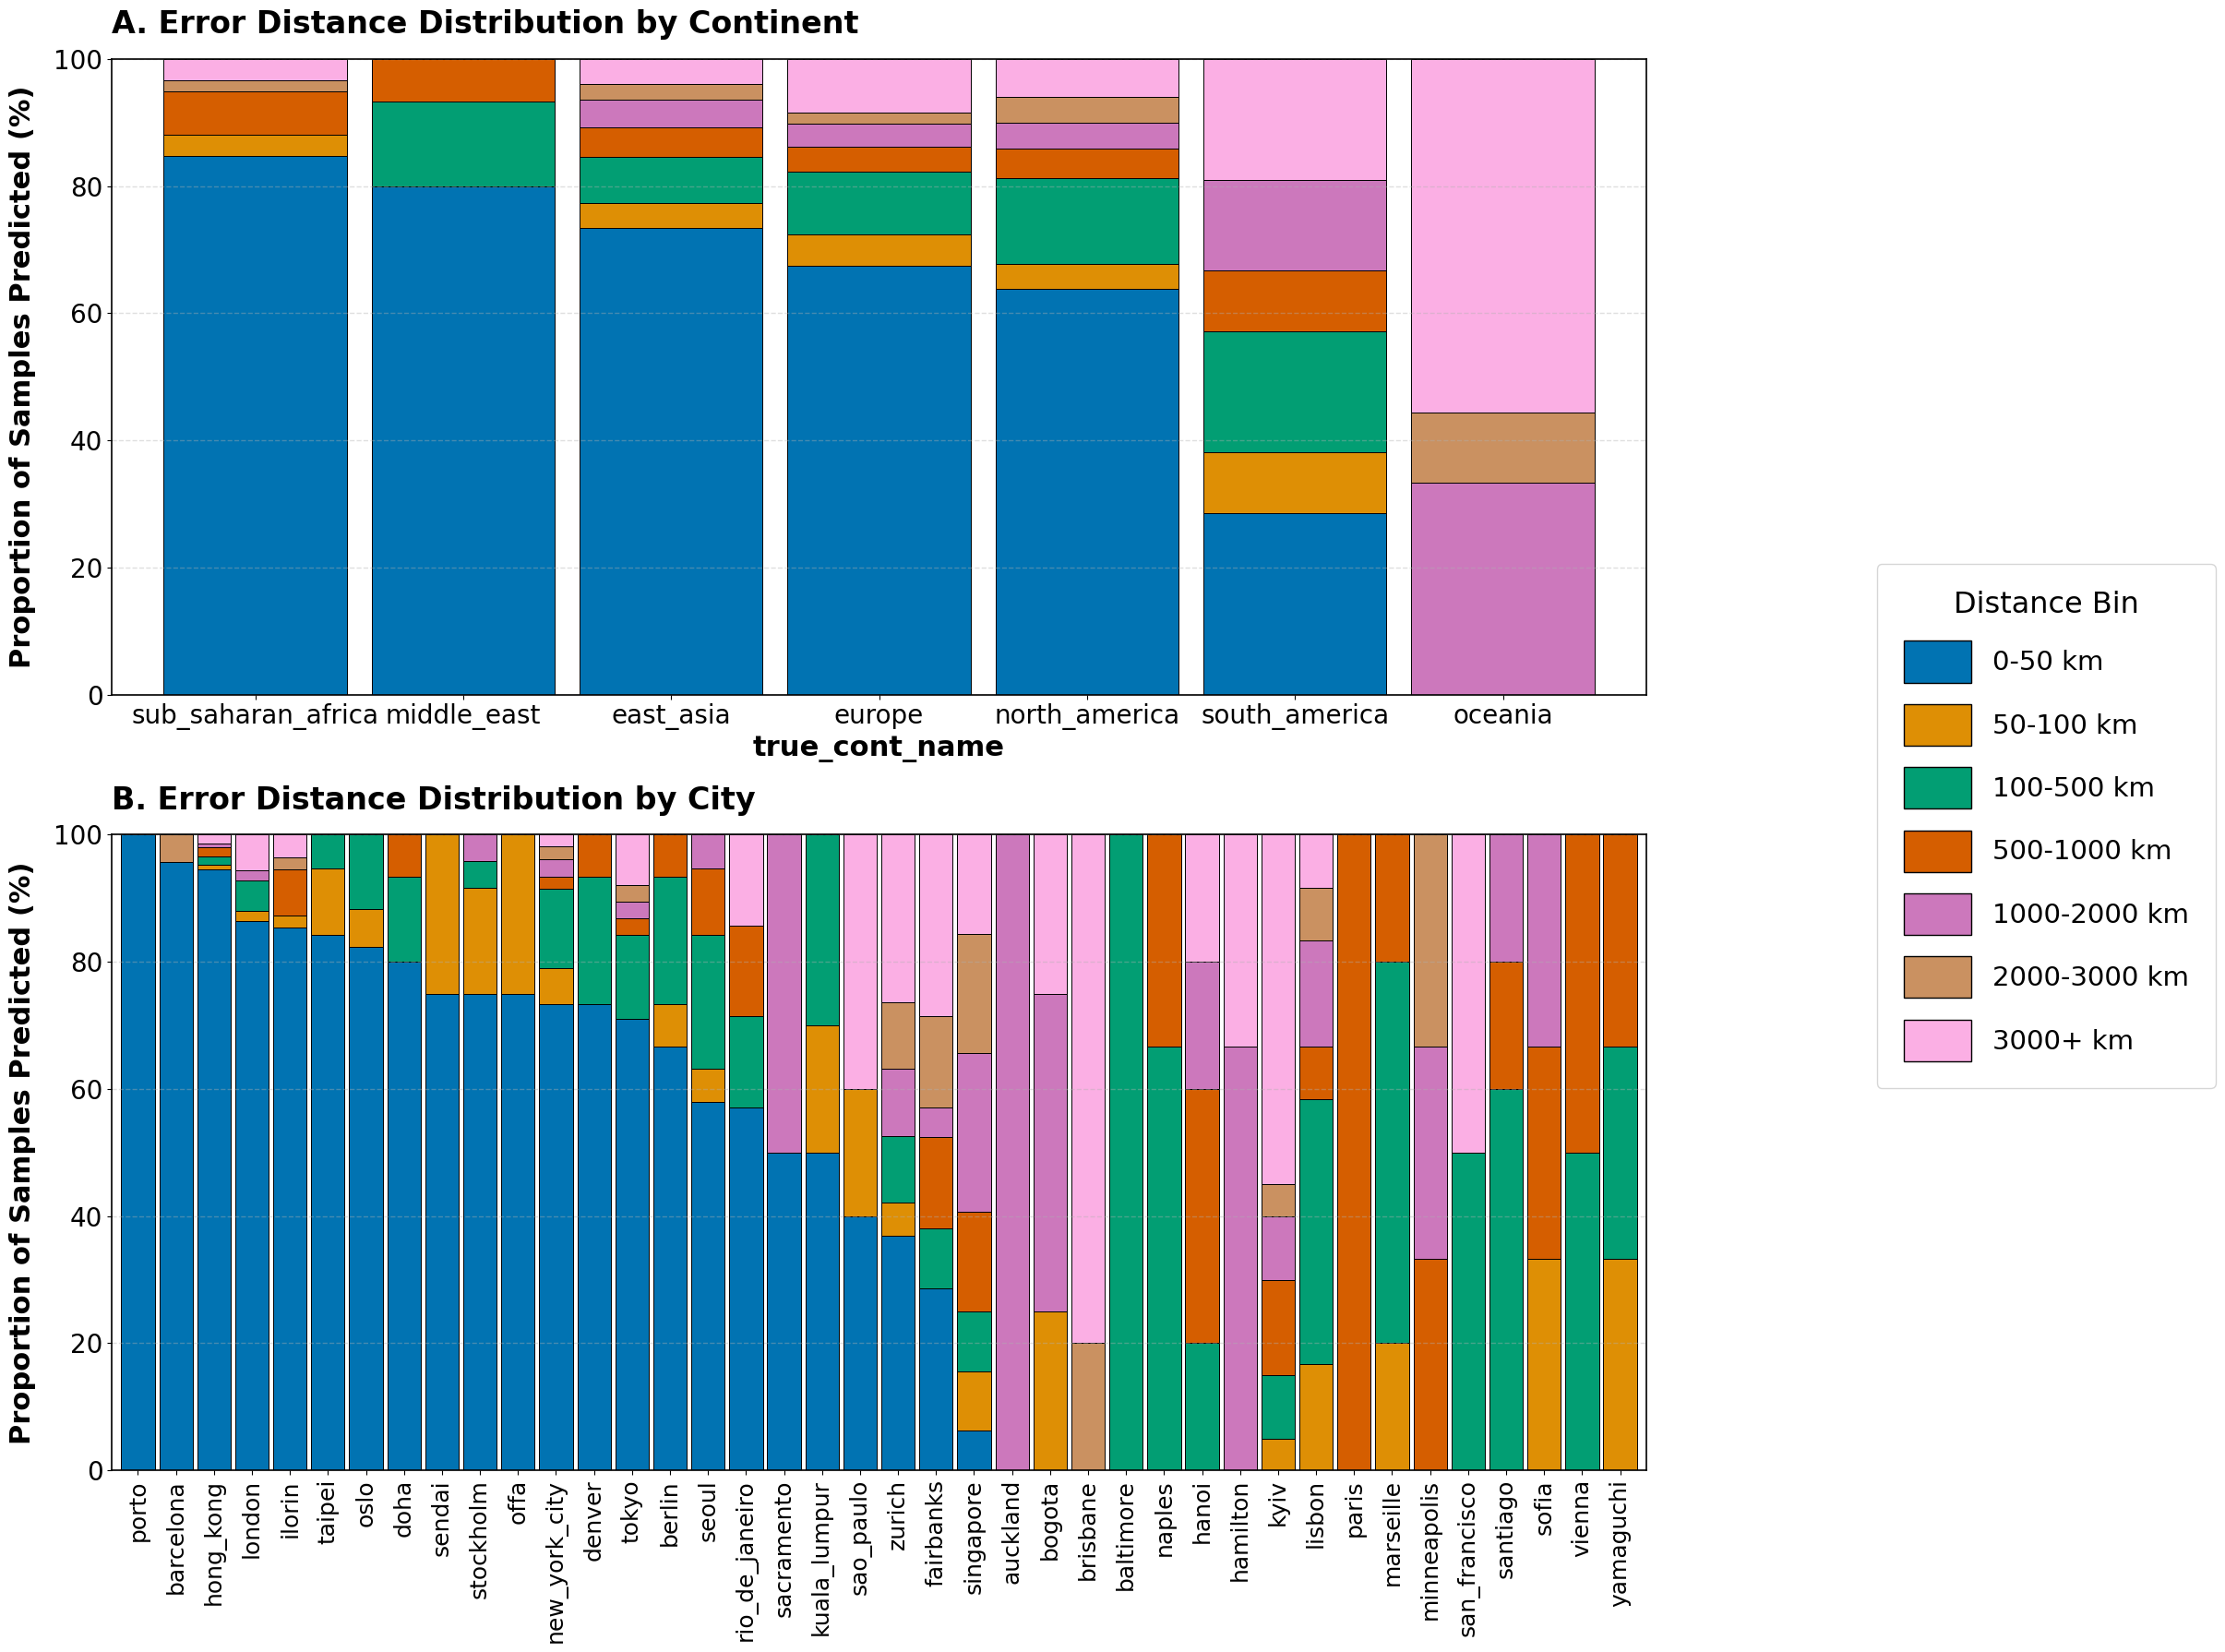

In [20]:
# Publication-quality subplot: Error distance distribution by continent and city with larger labels and legend
# Add a 0-50 km bin for finer granularity
def error_distribution_by_group(df, group_col, bins=[0, 50, 100, 500, 1000, 2000, 3000, float('inf')]):
    """
    Compute error distribution across distance bins by group
    """
    df = df.copy()
    bin_labels = [
        '0_50', '50_100', '100_500', 
        '500_1000', '1000_2000', '2000_3000', '3000plus'
    ]
    df['error_bin'] = pd.cut(
        df['coord_error'], 
        bins=bins, 
        labels=bin_labels, 
        right=True
    )
    result = pd.crosstab(
        index=df[group_col],
        columns=df['error_bin'],
        normalize='index'
    ) * 100
    for bin_name in bin_labels:
        if bin_name not in result.columns:
            result[bin_name] = 0
    return result[bin_labels]

# --- Publication-quality plotting ---

import matplotlib as mpl

# Use a modern, visually appealing palette (e.g., seaborn "Set2")
import seaborn as sns
# Use a colorblind-friendly, publication-quality palette (e.g., seaborn "colorblind")
colors = sns.color_palette("colorblind", 7)
legend_labels = ['0-50 km', '50-100 km', '100-500 km', '500-1000 km', '1000-2000 km', '2000-3000 km', '3000+ km']

mpl.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 22,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 21,
    'legend.title_fontsize': 23,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,
    'font.family': 'DejaVu Sans'
})

fig, axes = plt.subplots(2, 1, figsize=(22, 18), sharex=False, gridspec_kw={'height_ratios': [1, 1]})

# (A) Continent-level error distribution
error_dist = error_distribution_by_group(df, 'true_cont_name')
error_dist = error_dist.sort_values(by='0_50', ascending=False)
ax0 = axes[0]
bars = error_dist.plot(kind='bar', stacked=True, color=colors, width=0.88, ax=ax0, legend=False, edgecolor='black', linewidth=0.7)
ax0.set_ylabel('Proportion of Samples Predicted (%)', fontsize=22, labelpad=14, fontweight='bold')
ax0.set_title('A. Error Distance Distribution by Continent', fontsize=24, loc='left', fontweight='bold', pad=20)
ax0.set_ylim(0, 100)
ax0.tick_params(axis='x', labelsize=20, rotation=0)
ax0.tick_params(axis='y', labelsize=20)
ax0.grid(axis='y', linestyle='--', alpha=0.4, linewidth=1)


# (B) City-level error distribution
city_error_dist = error_distribution_by_group(df, 'true_city_name')
city_error_dist = city_error_dist.sort_values(by='0_50', ascending=False)
# Optionally, show only top N cities for clarity (uncomment below)
# top_cities = df['true_city_name'].value_counts().nlargest(20).index
# city_error_dist = city_error_dist.loc[top_cities]
ax1 = axes[1]
bars = city_error_dist.plot(kind='bar', stacked=True, color=colors, width=0.88, ax=ax1, legend=False, edgecolor='black', linewidth=0.7)
ax1.set_ylabel('Proportion of Samples Predicted (%)', fontsize=22, labelpad=14, fontweight='bold')
ax1.set_title('B. Error Distance Distribution by City', fontsize=24, loc='left', fontweight='bold', pad=20)
ax1.set_ylim(0, 100)
ax1.tick_params(axis='x', labelsize=18, rotation=90)
ax1.tick_params(axis='y', labelsize=20)
ax1.grid(axis='y', linestyle='--', alpha=0.4, linewidth=1)



# Add legend only once, outside the plots, with larger box and spacing, closer to the axes
from matplotlib.patches import Patch
handles = [Patch(facecolor=colors[i], edgecolor='black', label=legend_labels[i]) for i in range(len(legend_labels))]
legend = fig.legend(
    handles=handles,
    title='Distance Bin',
    bbox_to_anchor=(0.92, 0.5),  # Move legend closer to the plots
    loc='center left',
    fontsize=21,
    title_fontsize=23,
    frameon=True,
    borderpad=1.0,
    labelspacing=0.8,
    handleheight=2.0,
    handlelength=2.5
)
plt.tight_layout(rect=[0, 0, 0.89, 1])  # Reduce right margin to minimize white space
plt.subplots_adjust(hspace=0.22)

plt.xlabel('', fontsize=22)
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.subplots_adjust(hspace=0.22)
plt.show()

# Save the figure
fig.savefig('/home/chandru/binp37/report/figures/error_distance_distribution_by_continent_city.png', dpi=600, bbox_inches='tight')

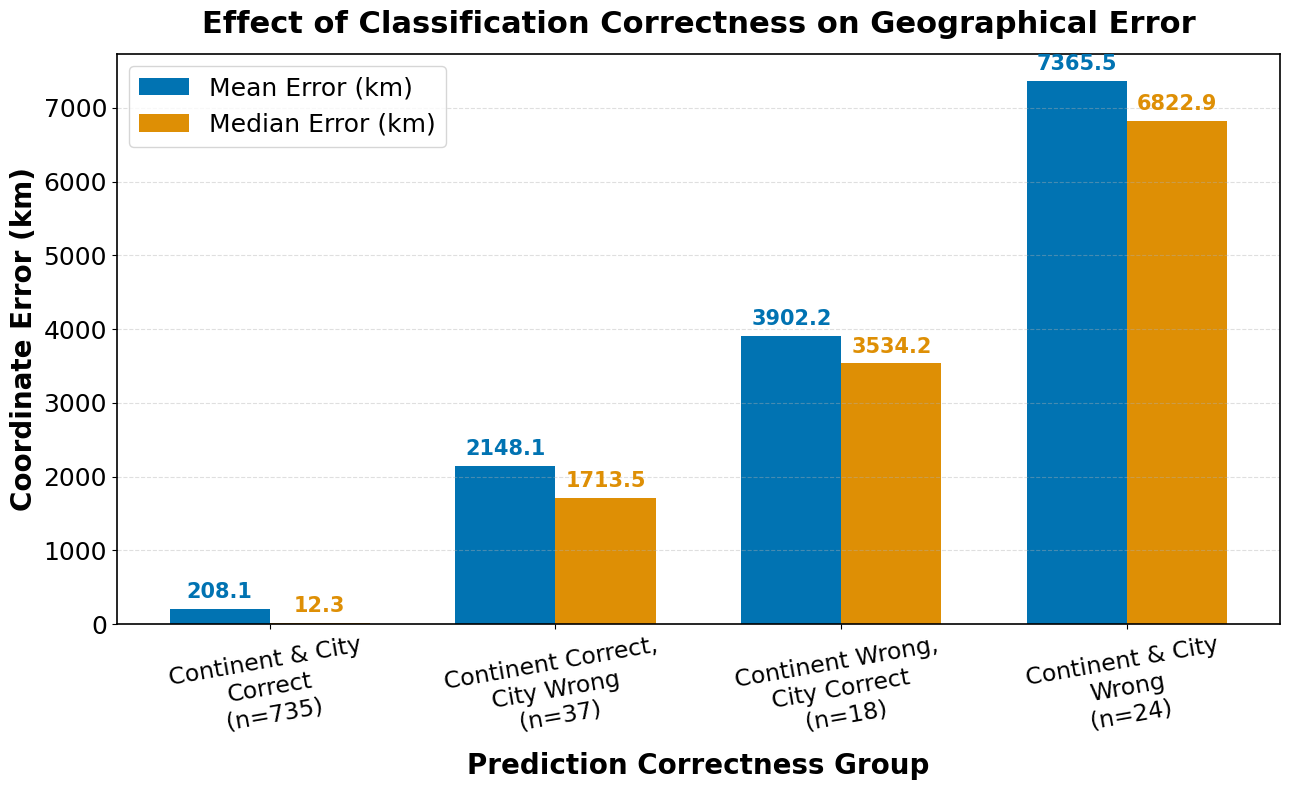

In [21]:
# Publication-quality plot: How classification correctness affects error

import matplotlib as mpl

mpl.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,
    'font.family': 'DejaVu Sans'
})

# Prepare data for plotting
plot_stats = group_stats.reset_index()
order = [
    'C_correct Z_correct',
    'C_correct Z_wrong',
    'C_wrong Z_correct',
    'C_wrong Z_wrong'
]
plot_stats = plot_stats.set_index('error_group').loc[order].reset_index()
# Add sample counts to x labels
plot_stats['Error Group'] = [
    f'Continent & City\nCorrect\n(n={plot_stats["count"].iloc[0]})',
    f'Continent Correct,\nCity Wrong\n(n={plot_stats["count"].iloc[1]})',
    f'Continent Wrong,\nCity Correct\n(n={plot_stats["count"].iloc[2]})',
    f'Continent & City\nWrong\n(n={plot_stats["count"].iloc[3]})'
]

fig, ax = plt.subplots(figsize=(13, 8))

bar_width = 0.35
x = np.arange(len(plot_stats))

# Use colorblind-friendly palette
colors = sns.color_palette("colorblind", 2)

# Plot mean and median bars
mean_bars = ax.bar(x - bar_width/2, plot_stats['mean_error_km'], bar_width, label='Mean Error (km)', color=colors[0])
median_bars = ax.bar(x + bar_width/2, plot_stats['median_error_km'], bar_width, label='Median Error (km)', color=colors[1])

# Annotate bars with colored text for clarity
for idx, rect in enumerate(mean_bars):
    height = rect.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=15, fontweight='bold', color=colors[0])
for idx, rect in enumerate(median_bars):
    height = rect.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=15, fontweight='bold', color=colors[1])

ax.set_ylabel('Coordinate Error (km)', fontsize=20, fontweight='bold')
ax.set_xlabel('Prediction Correctness Group', fontsize=20, fontweight='bold')
ax.set_title('Effect of Classification Correctness on Geographical Error', fontsize=22, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(plot_stats['Error Group'], fontsize=17, rotation=10, ha='center')
ax.legend(loc='upper left', fontsize=18, frameon=True)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('/home/chandru/binp37/report/figures/classification_correctness_vs_error.png', dpi=600, bbox_inches='tight')    

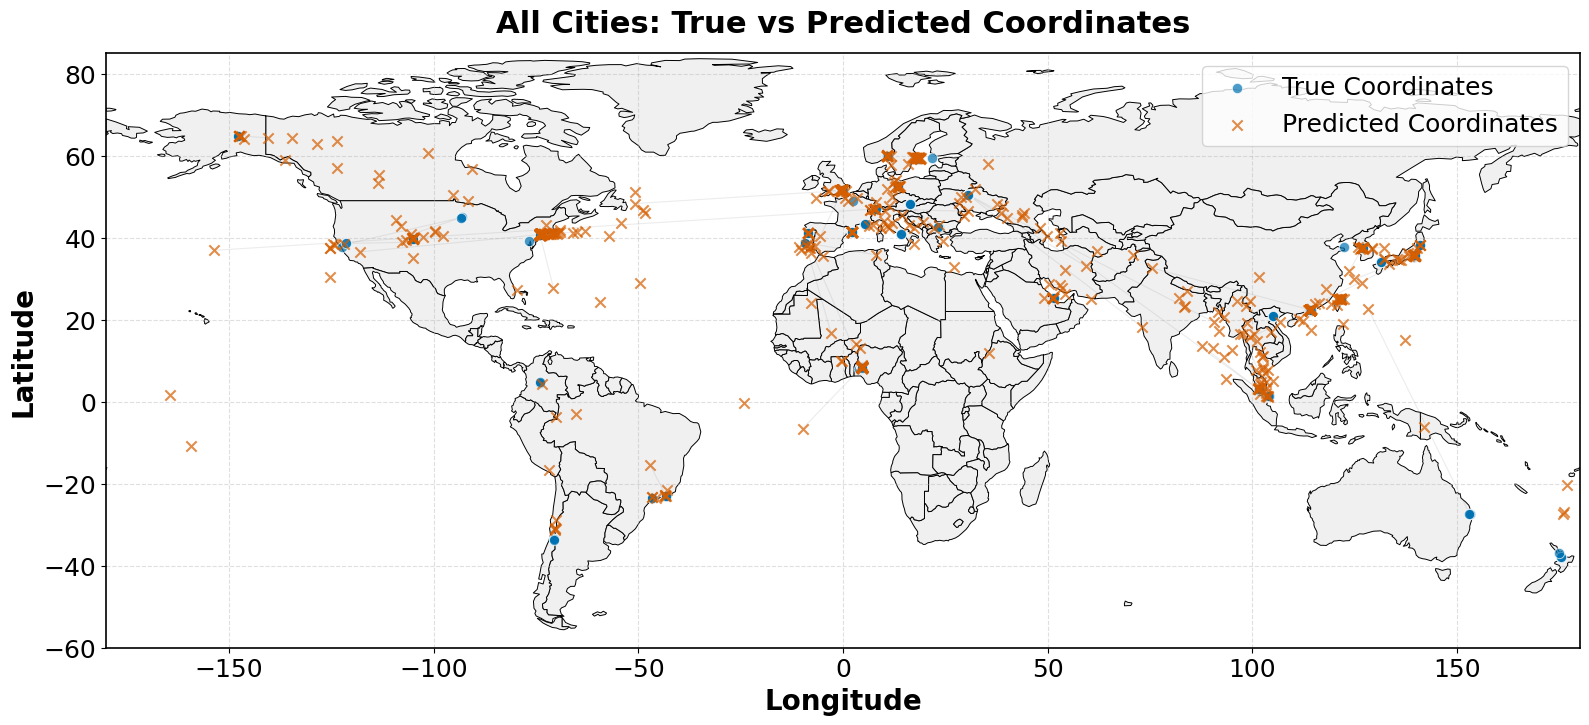

In [116]:
# Publication-quality plot: All true vs predicted coordinates on a world map
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd

# Set publication-quality style
mpl.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,
    'font.family': 'DejaVu Sans'
})

world = gpd.read_file("/home/chandru/binp37/data/geopandas/ne_110m_admin_0_countries.shp")

fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color='#f0f0f0', edgecolor='black', linewidth=0.7, zorder=0)

# Plot true coordinates
ax.scatter(df['true_lon'], df['true_lat'],
           color='#0072B2', label='True Coordinates',
           s=55, alpha=0.7, marker='o', edgecolor='white', linewidth=0.7, zorder=2)
# Plot predicted coordinates
ax.scatter(df['pred_lon'], df['pred_lat'],
           color='#D55E00', label='Predicted Coordinates',
           s=55, alpha=0.7, marker='x', linewidth=1.5, zorder=3)

# Optionally, add lines connecting true and predicted points for a subset
for i in range(0, len(df), max(1, len(df)//200)):  # Plot lines for a subset for clarity
    ax.plot([df['true_lon'].iloc[i], df['pred_lon'].iloc[i]],
            [df['true_lat'].iloc[i], df['pred_lat'].iloc[i]],
            color='gray', alpha=0.15, linewidth=0.8, zorder=1)

ax.set_title('All Cities: True vs Predicted Coordinates', fontsize=22, fontweight='bold', pad=15)
ax.set_xlabel('Longitude', fontsize=20, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=20, fontweight='bold')
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 85)
ax.legend(loc='upper right', frameon=True, fontsize=18)
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('/home/chandru/binp37/report/figures/world_true_vs_predicted_coords.png', dpi=600, bbox_inches='tight')